In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hydroeval as he
from datetime import datetime, timedelta
from pytz import timezone

In [154]:
#upload sensor data : bridge_5 data (2023/04/04-2023/05/20)

bridge_5= pd.read_csv('../20230612/bridge5_classification.csv', index_col=0)
bridge_5.index=pd.to_datetime(bridge_5.index)
labels=bridge_5['2023-04-04':'2023-05-20']['class']
s=bridge_5['2023-04-04':'2023-05-20']['Bridge5']
data=s.values.reshape(-1,1)

# Univariate detector
## KNNCAD Detector

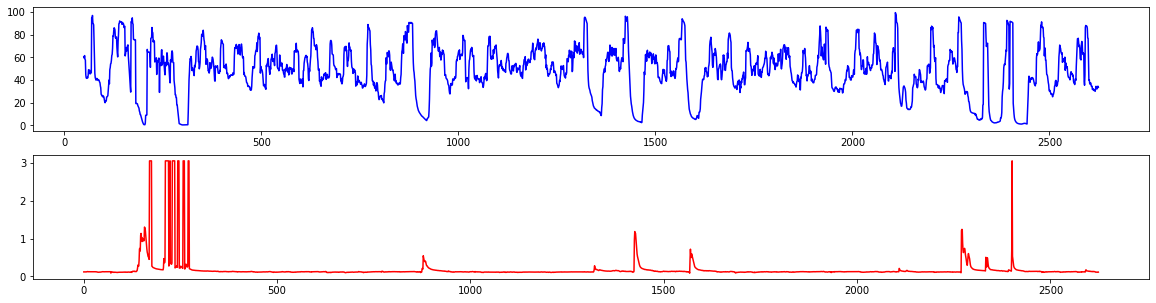

In [157]:
from streamad.util import StreamGenerator, UnivariateDS, plot
from streamad.model import KNNDetector

#evaluation of anomalies scores

stream = StreamGenerator(data)
model = KNNDetector(k_neighbor=20)
scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)

    
#visualization of scores and data

fig, ax = plt.subplots(2, 1,figsize=(20, 5))
ax[0].plot(scores, color='b')
ax[1].plot(data ,color='r')


#ROC evaluation at thresholds

thresholds = np.linspace(-1, 100, 100)
residuals=pd.DataFrame(scores)
detected_outliers = {}
is_outlier = []
is_outliers = []
detected={}

for threshold in thresholds: 
    detected={}
    for i in range(0,len(residuals.columns)):
        is_outlier = []
        is_outliers = []
        for j in residuals.iloc[:,i]:
            if j > threshold:
                is_outlier = False # Label point as outliers
                is_outliers.append(is_outlier)
            else:
                is_outlier = True # Label point as inlier
                is_outliers.append(is_outlier)
        
    detected={threshold: [is_outliers.copy()]}
    detected_outliers.update(detected)
        
#calculate true positive rate and false positive rate  

roc_tpr = []
roc_fpr = []

for threshold in thresholds:
    detector_result= np.array(detected_outliers[threshold])
    detector_result=detector_result
    label=labels.values

    TP = (detector_result & label).sum()
    FP = (detector_result & ~label).sum()
    P = (label).sum()
    N = (~label).sum()
    TPR = TP / P
    FPR = FP / N
    roc_tpr.append(TPR)
    roc_fpr.append(FPR)

KNN_roc_tpr_bridge5=roc_tpr
KNN_roc_fpr_bridge5=roc_fpr


## Spectral Residual Detector

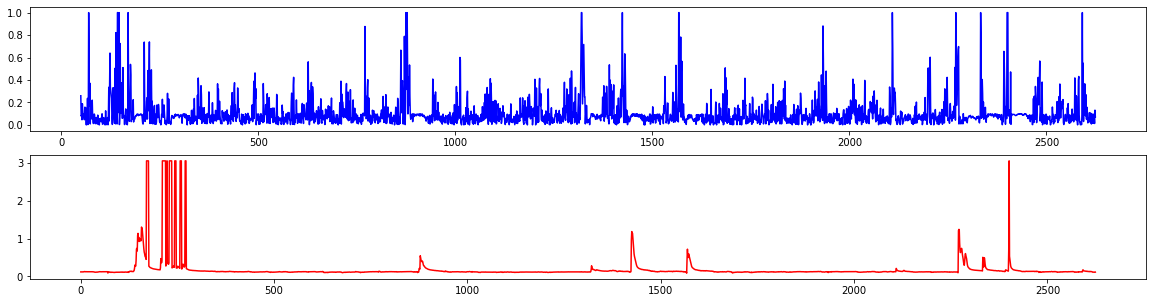

In [158]:
from streamad.util import StreamGenerator, UnivariateDS, plot
from streamad.model import SRDetector

#evaluation of anomalies scores
stream = StreamGenerator(data)
model = SRDetector()
scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)

#visualization of scores and data
fig, ax = plt.subplots(2, 1,figsize=(20, 5))
ax[0].plot(scores, color='b')
ax[1].plot(data ,color='r')

#ROC evaluation at thresholds
thresholds = np.linspace(0, 1, 50)
residuals=pd.DataFrame(scores)
detected_outliers = {}
is_outlier = []
is_outliers = []
detected={}

for threshold in thresholds: 
    detected={}
    for i in range(0,len(residuals.columns)):
        is_outlier = []
        is_outliers = []
        for j in residuals.iloc[:,i]:
            if j > threshold:
                is_outlier = False # Label point as outliers
                is_outliers.append(is_outlier)
            else:
                is_outlier = True # Label point as inlier
                is_outliers.append(is_outlier)
        
    detected={threshold: [is_outliers.copy()]}
    detected_outliers.update(detected)
    
#calculate true positive rate and false positive rate  
roc_tpr = []
roc_fpr = []

for threshold in thresholds:
    detector_result= np.array(detected_outliers[threshold])
    detector_result=detector_result
    label=labels.values

    TP = (detector_result & label).sum()
    FP = (detector_result & ~label).sum()
    P = (label).sum()
    N = (~label).sum()
    TPR = TP / P
    FPR = FP / N
    roc_tpr.append(TPR)
    roc_fpr.append(FPR)
    
SRD_roc_tpr_bridge5=roc_tpr
SRD_roc_fpr_bridge5=roc_fpr

## Z-score Detector -Select


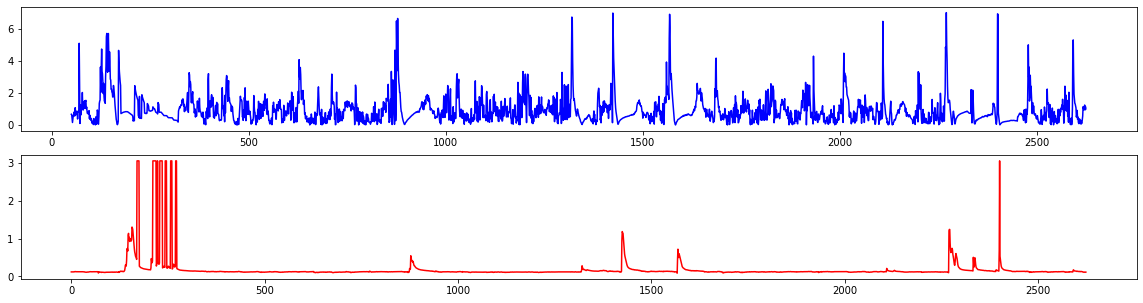

In [159]:
from streamad.util import StreamGenerator, UnivariateDS, plot
from streamad.model import ZScoreDetector

#evaluation of anomalies scores
stream = StreamGenerator(data)
model = ZScoreDetector()
scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)
    
#visualization of scores and data
fig, ax = plt.subplots(2, 1,figsize=(20, 5))
ax[0].plot(scores, color='b')
ax[1].plot(data ,color='r')

#ROC evaluation at thresholds
thresholds = np.linspace(0, 10, 50)
residuals=pd.DataFrame(scores)
detected_outliers = {}
is_outlier = []
is_outliers = []
detected={}

for threshold in thresholds: 
    detected={}
    for i in range(0,len(residuals.columns)):
        is_outlier = []
        is_outliers = []
        for j in residuals.iloc[:,i]:
            if j > threshold:
                is_outlier = False  # Label point as outlier
                is_outliers.append(is_outlier)
            else:
           
                is_outlier = True  # Label point as inlier
                is_outliers.append(is_outlier)
        

    detected={threshold: [is_outliers.copy()]}
    detected_outliers.update(detected)

#calculate true positive rate and false positive rate 
roc_tpr = [] 
roc_fpr = []

for threshold in thresholds:
    detector_result= np.array(detected_outliers[threshold])
    detector_result=detector_result
    label=labels.values

    TP = (detector_result & label).sum()
    FP = (detector_result & ~label).sum()
    P = (label).sum()
    N = (~label).sum()
    TPR = TP / P
    FPR = FP / N
    roc_tpr.append(TPR)
    roc_fpr.append(FPR)
    
Z_roc_tpr_bridge5=roc_tpr
Z_roc_fpr_bridge5=roc_fpr

## One-class SVM Detector

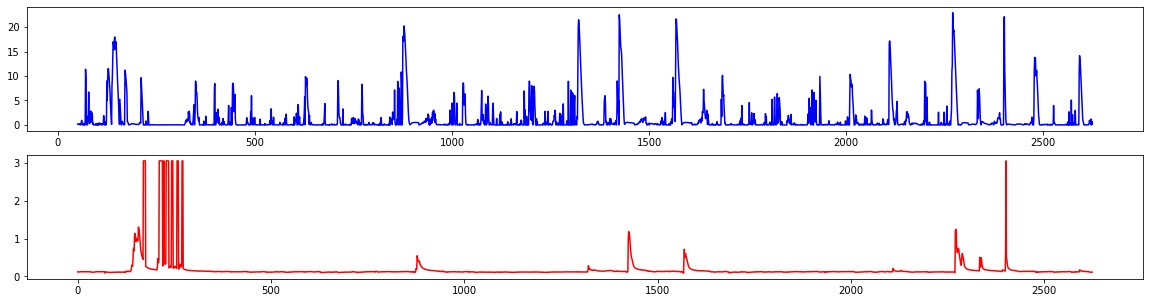

In [160]:
from streamad.util import StreamGenerator, UnivariateDS, plot
from streamad.model import OCSVMDetector

#evaluation of anomalies scores
stream = StreamGenerator(data)
model = OCSVMDetector()
scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)

#visualization of scores and data
fig, ax = plt.subplots(2, 1,figsize=(20, 5))
ax[0].plot(scores, color='b')
ax[1].plot(data ,color='r')

#ROC evaluation at thresholds
thresholds = np.linspace(-5, 30, 10)
residuals=pd.DataFrame(scores)
detected_outliers = {}
is_outlier = []
is_outliers = []
detected={}

for threshold in thresholds: 
    detected={}
    for i in range(0,len(residuals.columns)):
        is_outlier = []
        is_outliers = []
        for j in residuals.iloc[:,i]:
            if j > threshold:
                is_outlier = False # Label point as outlier
                is_outliers.append(is_outlier)
            else:
                is_outlier = True # Label point as inlier
                is_outliers.append(is_outlier)

    detected={threshold: [is_outliers.copy()]}
    detected_outliers.update(detected)

#calculate true positive rate and false positive rate 
roc_tpr = []
roc_fpr = []

for threshold in thresholds:
    detector_result= np.array(detected_outliers[threshold])
    detector_result=detector_result
    label=labels.values

    TP = (detector_result & label).sum()
    FP = (detector_result & ~label).sum()
    P = (label).sum()
    N = (~label).sum()
    TPR = TP / P
    FPR = FP / N
    roc_tpr.append(TPR)
    roc_fpr.append(FPR)
    
SVM_roc_tpr_bridge5=roc_tpr
SVM_roc_fpr_bridge5=roc_fpr

## RRCF

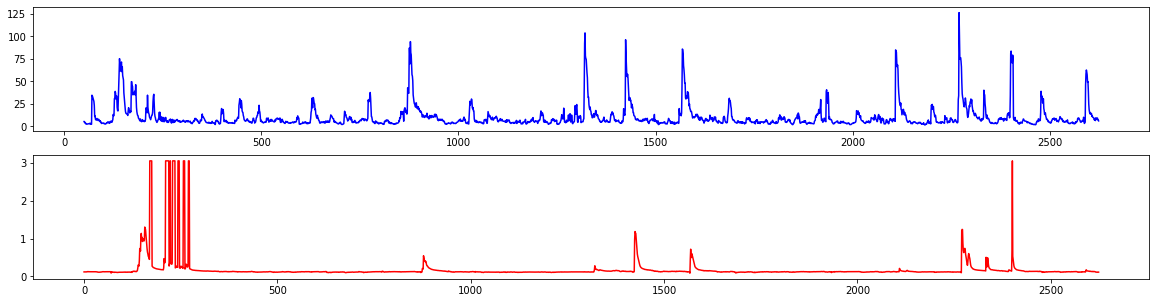

In [161]:
from streamad.util import StreamGenerator, UnivariateDS, plot
from streamad.model import RrcfDetector

#evaluation of anomalies scores
stream = StreamGenerator(data)
model = RrcfDetector(num_trees=100, tree_size=128,window_len=50)
scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)

#visualization of scores and data
fig, ax = plt.subplots(2, 1,figsize=(20, 5))
ax[0].plot(scores, color='b')
ax[1].plot(data ,color='r')

#ROC evaluation at thresholds
thresholds = np.linspace(-5, 200, 2000)
residuals=pd.DataFrame(scores)
detected_outliers = {}
is_outlier = []
is_outliers = []
detected={}

for threshold in thresholds: 
    detected={}
    for i in range(0,len(residuals.columns)):
        is_outlier = []
        is_outliers = []
        for j in residuals.iloc[:,i]:
            if j > threshold:
                is_outlier = False # Label point as outlier
                is_outliers.append(is_outlier)
            else:
                is_outlier = True # Label point as inlier
                is_outliers.append(is_outlier)
        
    detected={threshold: [is_outliers.copy()]}
    detected_outliers.update(detected)

#calculate true positive rate and false positive rate 
roc_tpr = []
roc_fpr = []

for threshold in thresholds:
    detector_result= np.array(detected_outliers[threshold])
    detector_result=detector_result
    label=labels.values

    TP = (detector_result & label).sum()
    FP = (detector_result & ~label).sum()
    P = (label).sum()
    N = (~label).sum()
    TPR = TP / P
    FPR = FP / N
    roc_tpr.append(TPR)
    roc_fpr.append(FPR)      
    
roc_rrfc_tpr_bridge5=roc_tpr
roc_rrfc_fpr_bridge5=roc_fpr

# Kalman Filter 

In [162]:
#Upload residuals of kf (anomalies scores)
residuals=pd.read_csv('residuals.csv',index_col=[0])
residuals.index=pd.to_datetime(residuals.index)
residuals=residuals.resample('5min').mean().interpolate(method='nearest')
#Set labels of kf 
measurements=bridge_5.resample('5min').mean().interpolate(method='nearest')
B5=(bridge_5.iloc[bridge_5.index.get_indexer(measurements.index, method='nearest')]
                     .set_index(measurements.index))
labels_kf=B5[residuals.index[0]:residuals.index[-1]]['class']


In [163]:
#ROC evaluation at thresholds
thresholds = np.linspace(-3, 8, 500)
detected_outliers = {}
is_outlier = []
is_outliers = []
detected={}

for threshold in thresholds: 
    detected={}
    for i in range(0,len(residuals.columns)):
        is_outlier = []
        is_outliers = []
        for j in residuals.iloc[:,i]:
            if j > threshold:
                is_outlier = False
                is_outliers.append(is_outlier)
            else:
            # Label point as inlier
                is_outlier = True
                is_outliers.append(is_outlier)
                    
        
        globals()[f'x{i}']=is_outliers.copy()
    detected={threshold: [x0,x1,x2,x3]}
    detected_outliers.update(detected)
    
#calculate true positive rate and false positive rate 
roc_tpr = []
roc_fpr = []

for threshold in thresholds:
    detector_result = np.array(detected_outliers[threshold][1])
    detector_result = detector_result[0:]
    label=labels[residuals.index[0]:residuals.index[-1]].values

    TP = (detector_result & labels_kf).sum()
    FP = (detector_result & ~labels_kf).sum()
    P = (labels_kf).sum()
    N = (~labels_kf).sum()
    TPR = TP / P
    FPR = FP / N
    roc_tpr.append(TPR)
    roc_fpr.append(FPR)
    
roc_fpr_kf_bridge5=roc_fpr
roc_tpr_kf_bridge5=roc_tpr


# KGE calcualtion

In [178]:
#upload all data 
#sensor data
s_2 = pd.read_csv('../20230612/bridge5_classification.csv', index_col=[0],converters={'0':pd.to_datetime})
s_2.index=pd.to_datetime(s_2.index)
sensor_2=s_2.loc[s_2['class'],'Bridge5']
sensor_outlier_2=s_2.loc[~s_2['class'],'Bridge5']

#model_kf_forecast
forecast_model_result_kf=pd.read_csv('h_j_kf_forecast.csv',index_col=[0],converters={'0':pd.to_datetime})
forecast_model_result_kf.index=pd.to_datetime(forecast_model_result_kf.index)
head_2_forecast_model_result_kf=forecast_model_result_kf['J_WLR18_COMB_HEMP']
#model_forecast
head_2_forecast_model_result_all=pd.read_csv('S2_forecast.csv',index_col=[0])
head_2_forecast_model_result_all.index=pd.to_datetime(head_2_forecast_model_result_all.index)
#model_raingauge
head_2_gauge_model_result_all=pd.read_csv('S2.csv',index_col=[0])
head_2_gauge_model_result_all.index=pd.to_datetime(head_2_gauge_model_result_all.index)

In [179]:
# resample to evaluate the simulation with sensor data
# Sensor data from node located near bridge_5 (named as Sensor_2 in Map figure)
sensor_2_resample=sensor_2.resample('5min').mean().interpolate(method='nearest')
# Simulation data 
head_2_forecast_model_result_kf_resample= head_2_forecast_model_result_kf.resample('5min').mean().interpolate(method='nearest')
head_2_gauge_model_result_all_resample=head_2_gauge_model_result_all.resample('5min').mean().interpolate(method='nearest')
head_2_forecast_model_result_all_resample=head_2_forecast_model_result_all.resample('5min').mean().interpolate(method='nearest')

In [180]:
#Separating three groups for KGE evaluation with box plot 
#Group1 duration(2023/04/05-2023/04/15)
evaluations_1=sensor_2_resample['2023-04-05':'2023-04-15']
simulations_1_v1=head_2_gauge_model_result_all_resample['2023-04-05':'2023-04-15']
simulations_1_v2=head_2_forecast_model_result_all_resample['2023-04-05':'2023-04-15']
simulations_1_v3=head_2_forecast_model_result_kf_resample['2023-04-05':'2023-04-15']
#Group2 duration(2023-04-16-2023-05-01)
evaluations_2=sensor_2_resample['2023-04-16':'2023-05-01']
simulations_2_v1=head_2_gauge_model_result_all_resample['2023-04-16':'2023-05-01']
simulations_2_v2=head_2_forecast_model_result_all_resample['2023-04-16':'2023-05-01']
simulations_2_v3=head_2_forecast_model_result_kf_resample['2023-04-16':'2023-05-01']
#Group3 duration(2023-05-02-2023-05-020)
evaluations_3=sensor_2_resample['2023-05-02':'2023-05-20 12:00:00']
simulations_3_v1=head_2_gauge_model_result_all_resample['2023-05-02':'2023-05-20 12:00:00']
simulations_3_v2=head_2_forecast_model_result_all_resample['2023-05-02':'2023-05-20 12:00:00']
simulations_3_v3=head_2_forecast_model_result_kf_resample['2023-05-02':'2023-05-20 12:00:00']


In [182]:
#Group1 KGE evaluation
kge_1_v1, r, alpha, beta = he.evaluator(he.kge, simulations_1_v1, evaluations_1)
kge_1_v2, r, alpha, beta = he.evaluator(he.kge, simulations_1_v2, evaluations_1)
kge_1_v3, r, alpha, beta = he.evaluator(he.kge, simulations_1_v3, evaluations_1)
#Group2 KGE evaluation
kge_2_v1, r, alpha, beta = he.evaluator(he.kge, simulations_2_v1, evaluations_2)
kge_2_v2, r, alpha, beta = he.evaluator(he.kge, simulations_2_v2, evaluations_2)
kge_2_v3, r, alpha, beta = he.evaluator(he.kge, simulations_2_v3, evaluations_2)
#Group3 dKGE evaluation
kge_3_v1, r, alpha, beta = he.evaluator(he.kge, simulations_3_v1, evaluations_3)
kge_3_v2, r, alpha, beta = he.evaluator(he.kge, simulations_3_v2, evaluations_3)
kge_3_v3, r, alpha, beta = he.evaluator(he.kge, simulations_3_v3, evaluations_3)

# Creating dataset for KGE box plot
data_1 = np.concatenate([kge_1_v1,kge_2_v1,kge_3_v1])
data_2 = np.concatenate([kge_1_v2,kge_2_v2,kge_3_v2])
data_3 = np.concatenate([kge_1_v3,kge_2_v3,kge_3_v3])
box = [data_2,data_1,data_3]

In [183]:
#Calculating AUC value 
kf_auc=np.trapz(roc_tpr_kf_bridge5, x=roc_fpr_kf_bridge5)
rrfc_auc=np.trapz(roc_rrfc_tpr_bridge5, x=roc_rrfc_fpr_bridge5)
KNN_auc=np.trapz(KNN_roc_tpr_bridge5, x=KNN_roc_fpr_bridge5)
Z_auc=np.trapz(Z_roc_tpr_bridge5, x=Z_roc_fpr_bridge5)
SVM_auc=np.trapz(SVM_roc_tpr_bridge5, x=SVM_roc_fpr_bridge5)
SRD_auc=np.trapz(SRD_roc_tpr_bridge5, x=SRD_roc_fpr_bridge5)

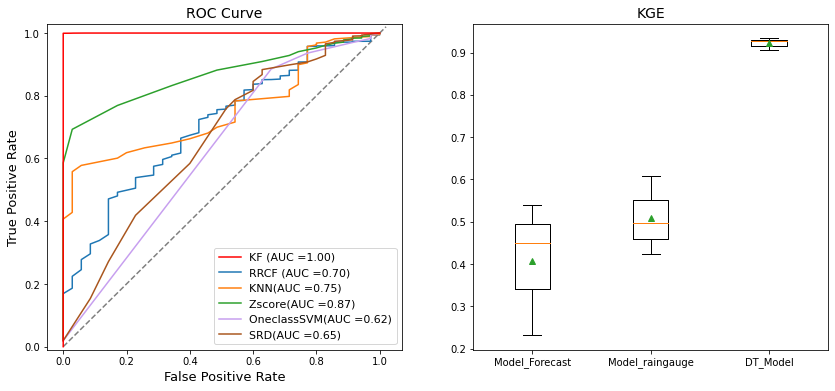

In [190]:
fig, ax = plt.subplots(1, 2,figsize=(14,6))
ax[0].plot(roc_fpr_kf_bridge5, roc_tpr_kf_bridge5,color='r',label='KF (AUC =%0.2f)' % kf_auc,zorder=3)
ax[0].plot(roc_rrfc_fpr_bridge5, roc_rrfc_tpr_bridge5,label='RRCF (AUC =%0.2f)' % rrfc_auc)
ax[0].plot(KNN_roc_fpr_bridge5, KNN_roc_tpr_bridge5, label='KNN(AUC =%0.2f)' %KNN_auc)
ax[0].plot(Z_roc_fpr_bridge5, Z_roc_tpr_bridge5, label='Zscore(AUC =%0.2f)' %Z_auc)
ax[0].plot(SVM_roc_fpr_bridge5, SVM_roc_tpr_bridge5, color='#C79FEF',label='OneclassSVM(AUC =%0.2f)' %SVM_auc)
ax[0].plot(SRD_roc_fpr_bridge5, SRD_roc_tpr_bridge5, color='#A9561E',label='SRD(AUC =%0.2f)' %SRD_auc)

ax[0].set_xlabel('False Positive Rate',fontsize=13)
ax[0].set_ylabel('True Positive Rate',fontsize=13)    
ax[0].set_title('ROC Curve',fontsize=14)
ax[0].set_ylim(-0.01, 1.03)
ax[0].plot([0, 1.02], [0, 1.02], linestyle='--', c='k', zorder=-1, alpha=0.5)
ax[0].legend(fontsize=11)

ax[1].set_title('KGE',fontsize=14)
ax[1].set_xticklabels(['Model_Forecast', 'Model_raingauge',
                    'DT_Model'])

# Creating plot
bp = ax[1].boxplot(box, showmeans=True)



# Viualization of Noise detection

Text(0, 0.5, 'Depth(m)')

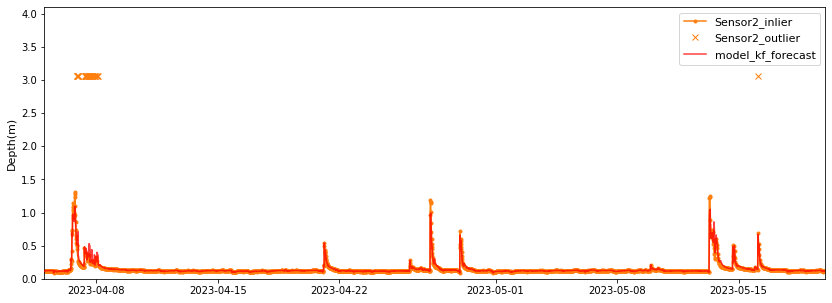

In [191]:

fig, ax = plt.subplots(1,figsize=(14, 5))

start=datetime(2023, 4, 5, 0 , 0, 0)
end=datetime(2023, 5, 20,0, 0, 0)

start_date=start
end_date=end

ax.set_xlim(start_date, end_date)


ax.set_ylim(0, 4.1)
utc = timezone('UTC')
central = timezone('US/Central')
start_gmt = start.replace(tzinfo=central)
end_gmt = end.replace(tzinfo=central)

start_cst = start_gmt.astimezone(utc)
end_cst = end_gmt.astimezone(utc)

start_time=start_cst.strftime("%Y-%m-%dT%H:%M:%SZ")
end_time=end_cst.strftime("%Y-%m-%dT%H:%M:%SZ")

start_date=start_time
end_date=end_time


ax.plot(sensor_2, label='Sensor2_inlier',marker='.',color='tab:orange')
ax.plot(sensor_outlier_2, label='Sensor2_outlier',linestyle='None',marker='x',color='tab:orange')
#ax.plot(head_2_forecast_model_result_all, label='Model_Forecast', color='b')
ax.plot(head_2_forecast_model_result_kf, label='model_kf_forecast',alpha=0.75, c='r',zorder=4)

ax.legend(fontsize=11)

ax.set_ylabel('Depth(m)',fontsize=11)

